# Data preparation

## Loading the dataset:

In [1]:
#!pip install numpy==1.20.0 --user
#!pip install xgboost tensorflow keras plotly pycountry pycountry_convert bioinfokit bayesian-optimization shap
#!pip install sklearn --upgrade --user
#!pip install --upgrade scipy.stats --user
#!pip install wbgapi

In [2]:
import pandas as pd
import numpy as np
import pycountry

# gaussian mixture
from sklearn.mixture import GaussianMixture

# Kernel density and LOF
from sklearn.neighbors import LocalOutlierFactor, KernelDensity, KDTree


#from sklearn.utils import indexable
#from sklearn.utils.validation import _num_samples

from math import sqrt, log, exp, floor
from sklearn.preprocessing import StandardScaler
#from sklearn.impute import KNNImputer

from sklearn.metrics import mean_squared_error, mean_absolute_error # for error reporting
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import savefig
matplotlib.style.use('seaborn')
import statsmodels.api as sm

In [3]:
gdp_df = pd.read_csv('data/wb_data.csv')

In [4]:
gdp_df.head()

,ISO3,Year,gdp_real_gwt,gdp_real_us_fixed,gdp_per_capita,gdp_pp_govt,gdp_pp_private,investment,inflation_pp,renew_energy,...,metal_exports,co2_emissions,ghg_emissions,industry_gdp,service_value_added,school_enroll,literacy,bachelor,homicide,research
0,ZWE,1990,6.988553,1.694150e+10,1623.930176,19.446133,63.105986,NaN,-0.920431,63.976409,...,15.910397,1.585444,NaN,29.803667,NaN,0.97075,NaN,NaN,5.626697,NaN
1,ZMB,1990,-0.481072,6.840844e+09,851.184841,NaN,NaN,NaN,106.388920,82.982734,...,NaN,0.340930,NaN,45.294071,NaN,NaN,64.998283,NaN,6.843478,NaN
2,YEM,1990,NaN,2.391779e+10,2042.512182,NaN,NaN,NaN,NaN,2.148638,...,NaN,0.567037,NaN,34.343661,NaN,NaN,NaN,NaN,NaN,NaN
3,PSE,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.082083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,VIR,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
full_countries_list = gdp_df.ISO3.unique()
gdp_df.columns

Index(['ISO3', 'Year', 'gdp_real_gwt', 'gdp_real_us_fixed', 'gdp_per_capita',
       'gdp_pp_govt', 'gdp_pp_private', 'investment', 'inflation_pp',
       'renew_energy', 'unemployment', 'employment', 'HCI', 'agric_employment',
       'vulnerable_employment', 'pop_slums', 'renew_freshwater', 'imports',
       'exports', 'foreign_inv', 'govt_debt', 'real_interest_rate',
       'poverty_1.90', 'poverty_3.20', 'poverty_5.50', 'poverty_multidim',
       'poverty_mult_index', 'gini_index', 'cab', 'population', 'pop_density',
       'pop_growth', 'life_expectancy', 'death_rate', 'child_mortality',
       'cause_of_death', 'renewable_energy_output', 'agric_land', 'agff_gdp',
       'arable_land', 'rural_pop', 'electricity_access', 'power_consumption',
       'fuel_exports', 'metal_exports', 'co2_emissions', 'ghg_emissions',
       'industry_gdp', 'service_value_added', 'school_enroll', 'literacy',
       'bachelor', 'homicide', 'research'],
      dtype='object')

In [6]:
df_mv = gdp_df.iloc[:,1:(gdp_df.shape[1]-3)]

In [7]:
print('% of NaN cells: '+str(
    df_mv.groupby('Year').apply(lambda x: x.isnull().sum()).iloc[:,1:].sum().sum()/(df_mv.iloc[:,1:].shape[0]*df_mv.iloc[:,1:].shape[1])))

% of NaN cells: 0.3804496892742059


-----------------------------
For this project, we are predicting the selected years 2002 to 2021, using **one-year lagged** data for all indexes

For GDP growth, due to the autorregressive nature, two-year lagged growth is used as well

------------------
The variable *gdp_real_gwt_next* is the **target** variable - the next year's GDP growth that is to be forecasted

All countries that lack key variables - GDP growth, government/private spending, CAB - are removed

In [8]:
# modify here to change years:
# start year and end year are the years to be predicted - 1
start_year = 2001 # forecasting from 2002
end_year = 2020 # forecasting until 2021

In [9]:
# lagging variables:

gdp_df.insert(2, 'gdp_real_gwt_prev', gdp_df.groupby(by="ISO3").shift(1)['gdp_real_gwt'], 'gdp_real_gwt_prev')
gdp_df.insert(2, 'gdp_real_gwt_next', gdp_df.groupby(by="ISO3").shift(-1)['gdp_real_gwt'], 'gdp_real_gwt_next')
gdp_df.insert(2, 'pop_growth_next', gdp_df.groupby(by="ISO3").shift(-1)['pop_growth'], 'pop_growth_next')

# selecting years:

gdp_df = gdp_df[gdp_df['Year']>=start_year]
gdp_df = gdp_df[gdp_df['Year']<=end_year]

# removing all countries with missing data in key variables (GDP, essential data like CAB and private/public expenditure):

gdp_df = gdp_df.loc[gdp_df.groupby('ISO3')['gdp_real_gwt_next'].filter(lambda x: len(x[pd.isnull(x)] ) < 1).index,:]
gdp_df = gdp_df.loc[gdp_df.groupby('ISO3')['gdp_real_gwt'].filter(lambda x: len(x[pd.isnull(x)] ) < 1).index,:]
gdp_df = gdp_df.loc[gdp_df.groupby('ISO3')['gdp_real_gwt_prev'].filter(lambda x: len(x[pd.isnull(x)] ) < 1).index,:]
gdp_df = gdp_df.loc[gdp_df.groupby('ISO3')['gdp_pp_govt'].filter(lambda x: len(x[pd.isnull(x)] ) < len(x)).index,:]
gdp_df = gdp_df.loc[gdp_df.groupby('ISO3')['gdp_pp_private'].filter(lambda x: len(x[pd.isnull(x)] ) < len(x)).index,:]
gdp_df = gdp_df.loc[gdp_df.groupby('ISO3')['cab'].filter(lambda x: len(x[pd.isnull(x)] ) < len(x)).index,:]

remaining_countries_list = gdp_df.ISO3.unique()

In [10]:
# checking which countries have been filtered out
removed_countries_list = list(set(full_countries_list) - set(remaining_countries_list))
print('Filtered countries: '+ str(len(removed_countries_list)))
print('Remaining countries: '+str(len(remaining_countries_list)))

Filtered countries: 111
Remaining countries: 155


In [11]:
# printing removed countries
# all countries with "NONE" printed have no recognized ISO3 code - often they are groups of countries, non-recognized nations, etcetera
for iso in removed_countries_list:
    try:
        print(iso + ' | ' + pycountry.countries.get(alpha_3=iso).name)
    except:
        print(iso + ' | ' + '------------ NONE ------------')  

GRL | Greenland
TUV | Tuvalu
HIC | ------------ NONE ------------
NAC | ------------ NONE ------------
MNA | ------------ NONE ------------
IDB | ------------ NONE ------------
VGB | Virgin Islands, British
SAS | ------------ NONE ------------
ASM | American Samoa
STP | Sao Tome and Principe
AFE | ------------ NONE ------------
OSS | ------------ NONE ------------
WLD | ------------ NONE ------------
IRN | Iran, Islamic Republic of
TSA | ------------ NONE ------------
SMR | San Marino
INX | ------------ NONE ------------
IDX | ------------ NONE ------------
YEM | Yemen
LIC | ------------ NONE ------------
DJI | Djibouti
SXM | Sint Maarten (Dutch part)
TTO | Trinidad and Tobago
QAT | Qatar
PLW | Palau
NRU | Nauru
GNQ | Equatorial Guinea
SSF | ------------ NONE ------------
SST | ------------ NONE ------------
NCL | New Caledonia
VEN | Venezuela, Bolivarian Republic of
TEA | ------------ NONE ------------
MEA | ------------ NONE ------------
SLB | Solomon Islands
GIB | Gibraltar
VCT | Sa

--------------------------------------
#### Benchmark for models

For assessing the performance of ML models, we need a benchmark; in this case, we select the next-year forecasts of the **World Economic Outlook**, from the International Monetary Fund

This forecast is produced twice a year - in fall and in spring

Source: https://www.imf.org/external/pubs/ft/weo/data/WEOhistorical.xlsx </br>
Extra material: https://www.elibrary.imf.org/view/journals/001/2021/216/article-A001-en.xml

Hence, we create a dataframe with all forecasts, assess the errors (MAE and MSE), and filter all countries that have missing values in forecasts

In [12]:
# discarding countries without a WEO forecast for the selected years:
gdp_df_copy = gdp_df.copy()

url = 'https://www.imf.org/external/pubs/ft/weo/data/WEOhistorical.xlsx'
weo_excel = pd.ExcelFile(url)
weo_excel.sheet_names
df_weo = pd.read_excel(url, sheet_name="ngdp_rpch")
s_weo = df_weo[df_weo.columns[(~df_weo.columns.str.startswith('F'))]]
f_weo = df_weo[df_weo.columns[(~df_weo.columns.str.startswith('S'))]]
df_weo_melt = df_weo.melt(id_vars=['country','WEO_Country_Code','ISOAlpha_3Code','year'], 
                          var_name="year_report",
                          value_name="gdp_pc_weo").dropna()
df_weo_melt = df_weo_melt[df_weo_melt.gdp_pc_weo!='.']
## obtaining one-year forecasts for each report:
weo_forecast_1S = df_weo_melt[(df_weo_melt.year_report.str.startswith('S')) & 
                              (df_weo_melt.year == df_weo_melt.year_report.str[1:5].astype('int') + 1)]
weo_forecast_1S.loc[:,'year_report'] = weo_forecast_1S.loc[:,'year'] - 1
weo_forecast_1S = weo_forecast_1S[(weo_forecast_1S.year_report >= start_year) & (weo_forecast_1S.year_report <= end_year)]
weo_forecast_1F = df_weo_melt[(df_weo_melt.year_report.str.startswith('F')) & 
                              (df_weo_melt.year == df_weo_melt.year_report.str[1:5].astype('int') + 1)]
weo_forecast_1F.loc[:,'year_report'] = weo_forecast_1F.loc[:,'year'] - 1
weo_forecast_1F = weo_forecast_1F[(weo_forecast_1F.year_report >= start_year) & (weo_forecast_1F.year_report <= end_year)]

merge_fc_1S = pd.merge(gdp_df_copy, weo_forecast_1S, how='left', left_on=['ISO3','Year'], right_on=['ISOAlpha_3Code','year_report'])
merge_fc_1F = pd.merge(gdp_df_copy, weo_forecast_1F, how='left', left_on=['ISO3','Year'], right_on=['ISOAlpha_3Code','year_report'])

nan_weo_forecast = merge_fc_1S[merge_fc_1S.gdp_pc_weo.isna()].ISO3.unique()
nan_weo_forecast = np.unique(np.concatenate([nan_weo_forecast, merge_fc_1F[merge_fc_1F.gdp_pc_weo.isna()].ISO3.unique()]))

nan_weo_forecast # prints the countries that have missing values in forecasts

C:\Users\ncozz\AppData\Local\Temp\ipykernel_11252\2683205603.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weo_forecast_1S.loc[:,'year_report'] = weo_forecast_1S.loc[:,'year'] - 1
C:\Users\ncozz\AppData\Local\Temp\ipykernel_11252\2683205603.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weo_forecast_1F.loc[:,'year_report'] = weo_forecast_1F.loc[:,'year'] - 1


array(['BMU', 'BRN', 'CYP', 'LBN', 'LBY', 'MAC', 'MHL', 'MNE', 'PSE',
       'SRB', 'UKR', 'ZWE'], dtype=object)

In [13]:
# countries with missing values for any WEO forecast
for iso in nan_weo_forecast:
    try:
        print(iso + ' | ' + pycountry.countries.get(alpha_3=iso).name)
    except:
        print(iso + ' | ' + '------------ NONE ------------')  

BMU | Bermuda
BRN | Brunei Darussalam
CYP | Cyprus
LBN | Lebanon
LBY | Libya
MAC | Macao
MHL | Marshall Islands
MNE | Montenegro
PSE | Palestine, State of
SRB | Serbia
UKR | Ukraine
ZWE | Zimbabwe


In [14]:
# removing such countries with missing WEO forecast from all dataframes
for nan_country in nan_weo_forecast.tolist():
    gdp_df = gdp_df[gdp_df.ISO3 != nan_country]
    merge_fc_1S = merge_fc_1S[merge_fc_1S.ISO3 != nan_country]
    merge_fc_1F = merge_fc_1F[merge_fc_1F.ISO3 != nan_country]

In [15]:
try:
    gdp_graph_df = gdp_df.copy() # this will be used later for graphs
    gdp_df = gdp_df.drop(columns=['pop_growth_next'], inplace=False)
except:
    pass

In [16]:
len(gdp_df)

2860

In [17]:
gdp_df.columns

Index(['ISO3', 'Year', 'gdp_real_gwt_next', 'gdp_real_gwt_prev',
       'gdp_real_gwt', 'gdp_real_us_fixed', 'gdp_per_capita', 'gdp_pp_govt',
       'gdp_pp_private', 'investment', 'inflation_pp', 'renew_energy',
       'unemployment', 'employment', 'HCI', 'agric_employment',
       'vulnerable_employment', 'pop_slums', 'renew_freshwater', 'imports',
       'exports', 'foreign_inv', 'govt_debt', 'real_interest_rate',
       'poverty_1.90', 'poverty_3.20', 'poverty_5.50', 'poverty_multidim',
       'poverty_mult_index', 'gini_index', 'cab', 'population', 'pop_density',
       'pop_growth', 'life_expectancy', 'death_rate', 'child_mortality',
       'cause_of_death', 'renewable_energy_output', 'agric_land', 'agff_gdp',
       'arable_land', 'rural_pop', 'electricity_access', 'power_consumption',
       'fuel_exports', 'metal_exports', 'co2_emissions', 'ghg_emissions',
       'industry_gdp', 'service_value_added', 'school_enroll', 'literacy',
       'bachelor', 'homicide', 'research'],
   

#### Cleaning data (continued):
We remove columns with over 30% of missing values

In [18]:
# dropping all variables with >30% missing values (arbitrary value)

cols_i = gdp_df.shape[1]
unemployment_col = gdp_df.unemployment # unemployment is kept due to it being a key indicator
gdp_df_columns1 = gdp_df.columns
gdp_df = gdp_df.dropna(thresh=len(gdp_df)*0.7, axis='columns')
gdp_df.insert(10, 'unemployment', unemployment_col)
cols_f = gdp_df.shape[1]
gdp_df.columns

Index(['ISO3', 'Year', 'gdp_real_gwt_next', 'gdp_real_gwt_prev',
       'gdp_real_gwt', 'gdp_real_us_fixed', 'gdp_per_capita', 'gdp_pp_govt',
       'gdp_pp_private', 'inflation_pp', 'unemployment', 'renew_energy',
       'agric_employment', 'vulnerable_employment', 'imports', 'exports',
       'foreign_inv', 'real_interest_rate', 'cab', 'population', 'pop_density',
       'pop_growth', 'life_expectancy', 'death_rate', 'child_mortality',
       'renewable_energy_output', 'agric_land', 'agff_gdp', 'arable_land',
       'rural_pop', 'electricity_access', 'fuel_exports', 'metal_exports',
       'co2_emissions', 'industry_gdp', 'service_value_added'],
      dtype='object')

In [19]:
# removed variables:
list(set(gdp_df.columns.tolist())^set(gdp_df_columns1.tolist()))

['employment',
 'investment',
 'school_enroll',
 'HCI',
 'pop_slums',
 'ghg_emissions',
 'research',
 'gini_index',
 'cause_of_death',
 'poverty_multidim',
 'homicide',
 'govt_debt',
 'poverty_1.90',
 'poverty_mult_index',
 'renew_freshwater',
 'literacy',
 'poverty_5.50',
 'bachelor',
 'poverty_3.20',
 'power_consumption']

In [20]:
print('Removed columns: '+str(cols_i - cols_f))

Removed columns: 20


In [21]:
gdp_df.shape

(2860, 36)

In [22]:
# observations for a random country (Chile)
pd.set_option("display.max_columns", None)
gdp_df[gdp_df['ISO3']=='CHL']

,ISO3,Year,gdp_real_gwt_next,gdp_real_gwt_prev,gdp_real_gwt,gdp_real_us_fixed,gdp_per_capita,gdp_pp_govt,gdp_pp_private,inflation_pp,unemployment,renew_energy,agric_employment,vulnerable_employment,imports,exports,foreign_inv,real_interest_rate,cab,population,pop_density,pop_growth,life_expectancy,death_rate,child_mortality,renewable_energy_output,agric_land,agff_gdp,arable_land,rural_pop,electricity_access,fuel_exports,metal_exports,co2_emissions,industry_gdp,service_value_added
3102,CHL,2001,3.202799,4.971621,3.154035,1.354091e+11,8726.997296,12.643098,61.715833,4.277147,10.39,32.15,13.60,28.360000,30.297456,31.847311,4.199763e+09,7.301564,-1.538273,15516112.0,20.868116,1.126199,76.634,5.345,10.3,54.261597,20.375720,4.062420,2.353631,13.637,97.115807,1.453511,40.693104,3.121272,28.482573,19656.749112
3368,CHL,2002,4.723245,3.154035,3.202799,1.397459e+11,8909.861523,12.748594,61.112430,3.340660,10.17,33.07,13.50,28.670000,30.226632,32.257220,2.549923e+09,4.274612,-0.825203,15684413.0,21.094469,1.078845,76.894,5.362,9.8,55.450986,20.933867,4.065033,2.219138,13.394,97.283684,1.188078,40.558279,3.131772,28.518035,20053.270908
3634,CHL,2003,6.674254,3.202799,4.723245,1.463465e+11,9233.421622,12.178188,59.994147,4.300301,9.77,31.62,13.60,28.850000,30.632445,35.060975,4.026498e+09,1.801028,-0.290420,15849649.0,21.316701,1.047994,77.146,5.384,9.5,50.156954,20.745577,4.094775,2.017398,13.335,98.782326,2.863205,41.032464,3.167263,29.715337,20278.111603
3900,CHL,2004,5.837046,4.723245,6.674254,1.561140e+11,9748.005092,11.430210,57.844424,7.024762,10.16,31.44,13.36,28.740001,30.203611,39.685750,6.797253e+09,-1.773195,2.847394,16014972.0,21.539049,1.037668,77.391,5.411,9.3,46.900875,21.431492,3.758266,2.017398,13.275,97.606087,2.254066,52.893311,3.432413,32.752502,21179.223005
4166,CHL,2005,6.049991,6.674254,5.837046,1.652265e+11,10210.060317,10.953631,57.490059,7.120315,9.34,32.26,13.16,26.970001,31.886962,40.175572,7.462207e+09,-0.413027,1.491743,16182713.0,21.764649,1.041954,77.630,5.442,9.1,53.883088,21.364245,3.922212,1.950151,13.217,97.765312,2.808988,56.323590,3.458629,34.035302,21545.079245
4432,CHL,2006,5.168231,5.837046,6.049991,1.752227e+11,10714.029011,10.297115,53.496851,12.349896,9.02,32.91,12.85,26.000000,29.845961,43.865674,7.586190e+09,-3.872201,4.552926,16354507.0,21.995700,1.055994,77.865,5.476,9.0,55.254881,21.249926,3.712045,1.815658,13.158,99.368111,2.433717,62.520561,3.494450,38.684729,22369.665710
4698,CHL,2007,3.789393,6.049991,5.168231,1.842786e+11,11147.993566,10.545955,53.823343,5.088757,8.43,30.46,12.31,24.820001,31.847173,45.129852,1.347476e+10,3.409024,4.301548,16530201.0,22.231997,1.068555,78.099,5.511,8.9,44.155600,21.158471,3.550571,1.697304,13.100,98.092018,1.852531,64.455330,3.906184,37.466597,23098.187103
4964,CHL,2008,-1.118037,5.168231,3.789393,1.912616e+11,11447.132776,11.264929,58.189633,0.311132,9.29,30.83,11.72,24.370000,39.514065,41.162561,1.847310e+10,12.910470,-3.728374,16708255.0,22.471467,1.071384,78.330,5.549,8.9,45.749029,21.228407,3.424432,1.764551,13.041,98.264870,2.379778,55.881831,4.069246,31.983991,23370.556630
5230,CHL,2009,5.851651,3.789393,-1.118037,1.891232e+11,11199.880173,12.868528,56.666226,3.577795,11.31,31.53,11.18,23.269999,29.570396,37.115635,1.385513e+10,3.545972,1.878518,16886184.0,22.710770,1.059286,78.558,5.588,8.8,48.827443,21.225717,3.697127,1.761861,12.983,99.593658,1.461916,58.448929,3.875950,31.889201,23123.165216
5496,CHL,2010,6.223897,-1.118037,5.851651,2.001901e+11,11732.729994,12.546177,56.588047,8.857441,8.41,27.04,10.61,21.810000,31.813686,37.903994,1.601968e+10,-3.768796,1.413502,17062531.0,22.947944,1.038912,78.779,5.631,8.7,40.202535,21.173265,3.478285,1.709409,12.926,99.538391,0.937954,63.566294,4.087905,33.466903,23060.273148


In [23]:
# pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 20)

#### Calculating MAE and RMSE of WEO forecasts (benchmark referred to previously):
We come back to this later in the next notebook

Errors are calculated from 2002 onwards, considering walking forward CV - again, more on this later ;)

In [24]:
def mse_forecast_scaled(y_true, y_pred):
    scaler = StandardScaler()
    scaler.fit(np.asarray(y_true).reshape(-1,1))
    y_true = scaler.transform(np.asarray(y_true).reshape(-1,1))
    y_pred = scaler.transform(np.asarray(y_pred).reshape(-1,1))
    return mean_squared_error(y_true, y_pred)

def mae_forecast_scaled(y_true, y_pred):
    scaler = StandardScaler()
    scaler.fit(np.asarray(y_true).reshape(-1,1))
    y_true = scaler.transform(np.asarray(y_true).reshape(-1,1))
    y_pred = scaler.transform(np.asarray(y_pred).reshape(-1,1))
    return mean_absolute_error(y_true, y_pred)

Years 2003 onwards:

In [25]:
mae_forecast_scaled(merge_fc_1S[merge_fc_1S.Year>=(start_year+1)].gdp_real_gwt_next, merge_fc_1S[merge_fc_1S.Year>=(start_year+1)].gdp_pc_weo)

0.5834040284603731

In [26]:
mse_forecast_scaled(merge_fc_1S[merge_fc_1S.Year>=(start_year+1)].gdp_real_gwt_next, merge_fc_1S[merge_fc_1S.Year>=(start_year+1)].gdp_pc_weo)

0.8867834654082841

In [27]:
mae_forecast_scaled(merge_fc_1F[merge_fc_1F.Year>=(start_year+1)].gdp_real_gwt_next, merge_fc_1F[merge_fc_1F.Year>=(start_year+1)].gdp_pc_weo)

0.5492101955635692

In [28]:
mse_forecast_scaled(merge_fc_1F[merge_fc_1F.Year>=(start_year+1)].gdp_real_gwt_next, merge_fc_1F[merge_fc_1F.Year>=(start_year+1)].gdp_pc_weo)

0.8563985783538146

--------------------------
## Data exploration
We introduce here basic descriptive statistics </br>
For this purpose, we construct a set with the latest values available for each covariate, per country


This section is for exploratory purposes, and can be adjusted at will depending on the needs of the research project

### Panel data plots:

In [29]:
gdp_graph_df['gdp_growth_converted'] = ((gdp_graph_df.gdp_real_gwt_next + 100)/100)
gdp_graph_df['pop_growth_converted'] = ((gdp_graph_df.pop_growth_next + 100)/100)
gdp_graph_df['gdp_pc_growth'] = gdp_graph_df['gdp_growth_converted'] / gdp_graph_df['pop_growth_converted']

In [30]:
# maximum total growth
gdp_graph_df.gdp_growth_converted.max()

1.533817941825641

<AxesSubplot:title={'center':'Accumulated GDP growth, highest 20 countries, 2001-2021'}, xlabel='ISO3'>

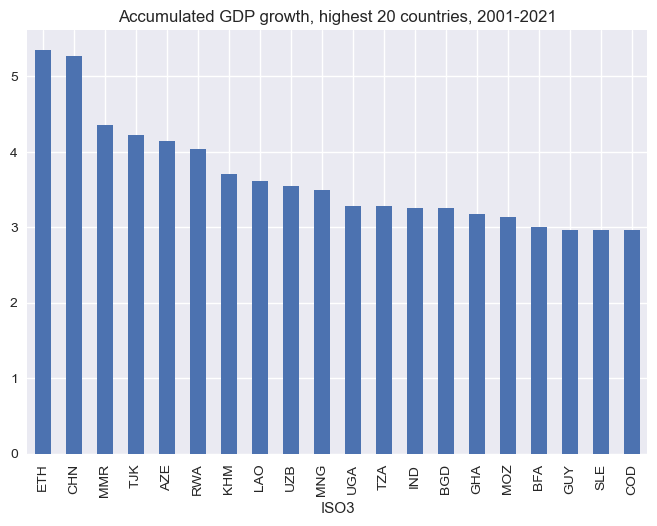

In [31]:
# accumulated GDP growth for the selected years, highest 30

gwt_pivot = gdp_graph_df.pivot_table(values='gdp_growth_converted',
                                index='Year',
                                columns=['ISO3'])
gwt_pivot.index = pd.to_datetime(gwt_pivot.index, format='%Y')
gwt_pivot.prod().sort_values(ascending=False)[:20].plot(kind='bar',
                                                       title = 'Accumulated GDP growth, highest 20 countries, 2001-2021')

In [32]:
maxc = 20
for i in range(maxc):
    country = gwt_pivot.prod().sort_values(ascending=False).index[i]
    gwt = gwt_pivot.prod().sort_values(ascending=False).values[i].round(3)
    try:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + pycountry.countries.get(alpha_3=country).name)
    except:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + '------------ NONE ------------')

01 | 5.344 | Ethiopia
02 | 5.266 | China
03 | 4.348 | Myanmar
04 | 4.218 | Tajikistan
05 | 4.137 | Azerbaijan
06 | 4.036 | Rwanda
07 | 3.709 | Cambodia
08 | 3.617 | Lao People's Democratic Republic
09 | 3.544 | Uzbekistan
10 | 3.491 | Mongolia
11 | 3.279 | Uganda
12 | 3.274 | Tanzania, United Republic of
13 | 3.257 | India
14 | 3.253 | Bangladesh
15 | 3.170 | Ghana
16 | 3.138 | Mozambique
17 | 3.002 | Burkina Faso
18 | 2.967 | Guyana
19 | 2.964 | Sierra Leone
20 | 2.957 | Congo, The Democratic Republic of the


<AxesSubplot:title={'center':'Countries with lowest GDP growth, 2001-2021'}, xlabel='ISO3'>

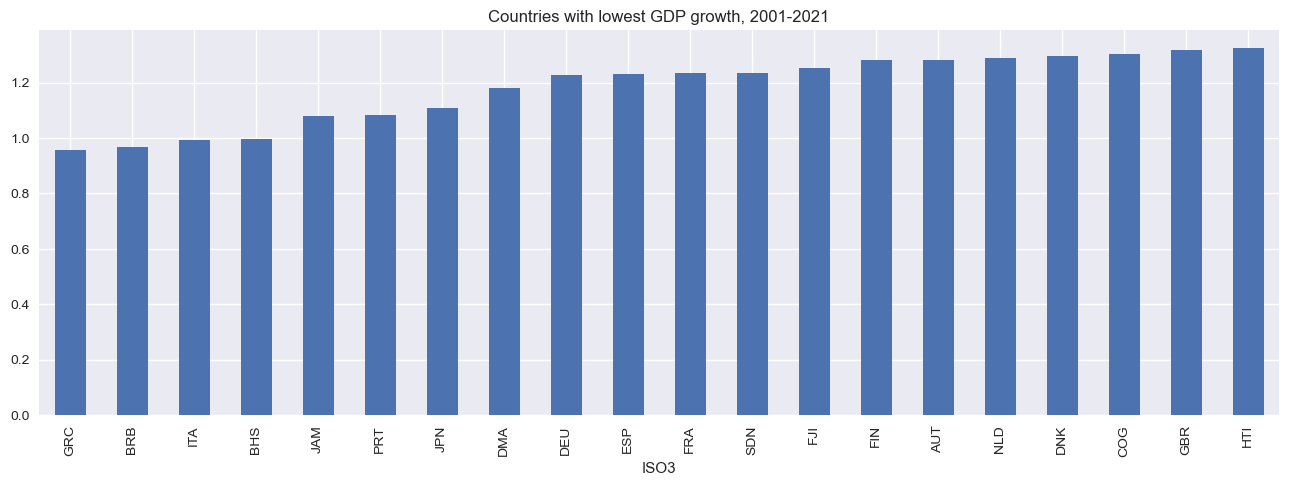

In [33]:
# accumulated GDP growth for the selected years, lowest 30
plt.rcParams["figure.figsize"] = (16, 5)
gwt_pivot.prod().sort_values(ascending=True)[:20].plot(kind='bar', title="Countries with lowest GDP growth, 2001-2021")

In [34]:
maxc = 20
for i in range(maxc):
    country = gwt_pivot.prod().sort_values(ascending=True).index[i]
    gwt = gwt_pivot.prod().sort_values(ascending=True).values[i].round(3)
    try:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + pycountry.countries.get(alpha_3=country).name)
    except:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + '------------ NONE ------------')

01 | 0.957 | Greece
02 | 0.968 | Barbados
03 | 0.991 | Italy
04 | 0.995 | Bahamas
05 | 1.079 | Jamaica
06 | 1.083 | Portugal
07 | 1.108 | Japan
08 | 1.180 | Dominica
09 | 1.226 | Germany
10 | 1.230 | Spain
11 | 1.236 | France
12 | 1.236 | Sudan
13 | 1.251 | Fiji
14 | 1.280 | Finland
15 | 1.281 | Austria
16 | 1.288 | Netherlands
17 | 1.294 | Denmark
18 | 1.304 | Congo
19 | 1.319 | United Kingdom
20 | 1.323 | Haiti


<AxesSubplot:title={'center':'Countries with highest GDP per capita growth, 2001-2021'}, xlabel='ISO3'>

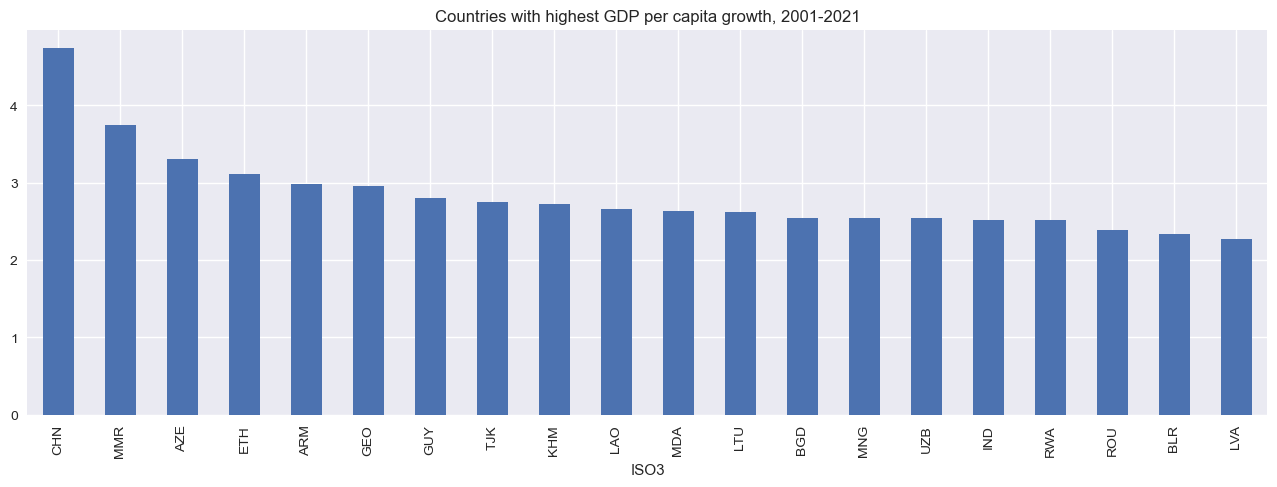

In [35]:
# same as above, but per capita

gwt_pc_pivot = gdp_graph_df.pivot_table(values='gdp_pc_growth',
                                index='Year',
                                columns=['ISO3'])
gwt_pc_pivot.index = pd.to_datetime(gwt_pivot.index, format='%Y')
plt.rcParams["figure.figsize"] = (16, 5)
gwt_pc_pivot.prod().sort_values(ascending=False)[:20].plot(kind='bar', title="Countries with highest GDP per capita growth, 2001-2021")

In [36]:
maxc = 20
for i in range(maxc):
    country = gwt_pc_pivot.prod().sort_values(ascending=False).index[i]
    gwt = gwt_pc_pivot.prod().sort_values(ascending=False).values[i].round(3)
    try:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + pycountry.countries.get(alpha_3=country).name)
    except:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + '------------ NONE ------------')

01 | 4.743 | China
02 | 3.749 | Myanmar
03 | 3.312 | Azerbaijan
04 | 3.113 | Ethiopia
05 | 2.984 | Armenia
06 | 2.956 | Georgia
07 | 2.798 | Guyana
08 | 2.746 | Tajikistan
09 | 2.722 | Cambodia
10 | 2.658 | Lao People's Democratic Republic
11 | 2.640 | Moldova, Republic of
12 | 2.623 | Lithuania
13 | 2.548 | Bangladesh
14 | 2.544 | Mongolia
15 | 2.542 | Uzbekistan
16 | 2.517 | India
17 | 2.517 | Rwanda
18 | 2.390 | Romania
19 | 2.330 | Belarus
20 | 2.267 | Latvia


<AxesSubplot:title={'center':'Countries with lowest GDP per capita growth, 2001-2021'}, xlabel='ISO3'>

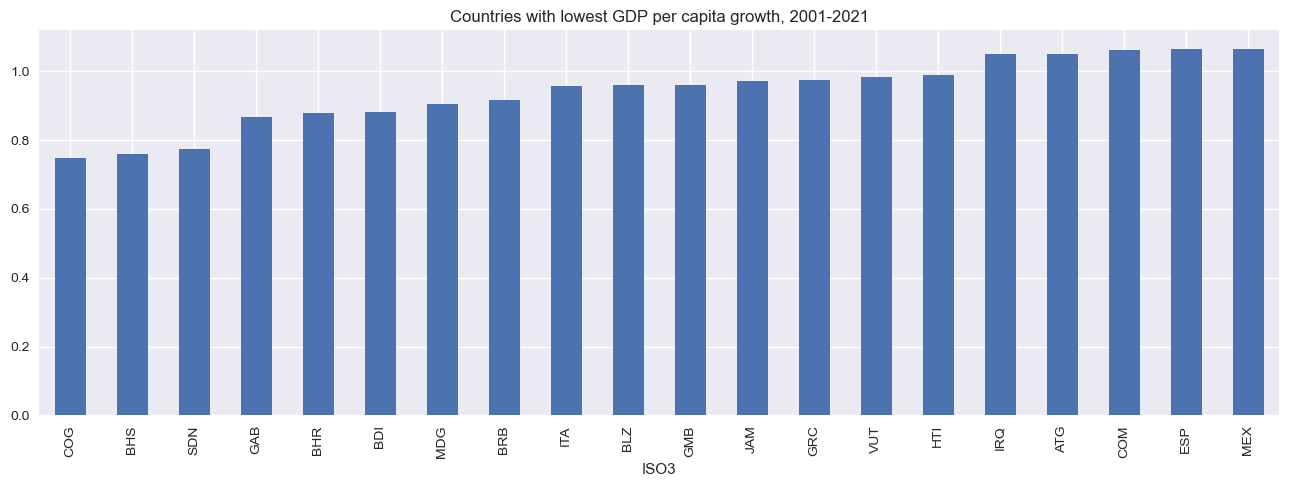

In [37]:
gwt_pc_pivot.prod().sort_values(ascending=True)[:20].plot(kind='bar', title="Countries with lowest GDP per capita growth, 2001-2021")

In [38]:
maxc = 20
for i in range(maxc):
    country = gwt_pc_pivot.prod().sort_values(ascending=True).index[i]
    gwt = gwt_pc_pivot.prod().sort_values(ascending=True).values[i].round(3)
    try:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + pycountry.countries.get(alpha_3=country).name)
    except:
        print(str('%02d' % (i+1)) + ' | ' + str('%.3f' % gwt) + ' | ' + '------------ NONE ------------')

01 | 0.748 | Congo
02 | 0.760 | Bahamas
03 | 0.774 | Sudan
04 | 0.867 | Gabon
05 | 0.878 | Bahrain
06 | 0.883 | Burundi
07 | 0.904 | Madagascar
08 | 0.917 | Barbados
09 | 0.956 | Italy
10 | 0.959 | Belize
11 | 0.960 | Gambia
12 | 0.971 | Jamaica
13 | 0.975 | Greece
14 | 0.982 | Vanuatu
15 | 0.989 | Haiti
16 | 1.050 | Iraq
17 | 1.051 | Antigua and Barbuda
18 | 1.062 | Comoros
19 | 1.063 | Spain
20 | 1.065 | Mexico


#### Dataframe for the next plots:

In [39]:
gdp_growth_total = ((gdp_df.gdp_real_gwt + 100)/100)
gdp_growth_total = pd.DataFrame({'ISO3': gdp_df['ISO3'], 'gdp_growth_total': gdp_growth_total})
gdp_growth_total = gdp_growth_total.groupby('ISO3', as_index=False).prod().gdp_growth_total

pop_growth_total = ((gdp_df.pop_growth + 100)/100)
pop_growth_total = pd.DataFrame({'ISO3': gdp_df['ISO3'], 'pop_growth_total': pop_growth_total})
pop_growth_total = pop_growth_total.groupby('ISO3', as_index=False).prod().pop_growth_total

In [40]:
gdp_sns_plots = gdp_df.groupby('ISO3', as_index=False).last()
gdp_sns_plots['gdp_per_capita'] = gdp_sns_plots.gdp_real_us_fixed / gdp_sns_plots.population
gdp_sns_plots['log_gdp_per_capita'] = np.log(gdp_sns_plots.gdp_per_capita)
gdp_sns_plots['gdp_growth_total'] = gdp_growth_total
gdp_sns_plots['pop_growth_total'] = pop_growth_total
gdp_sns_plots['gdp_pc_growth_total'] = gdp_growth_total / pop_growth_total
gdp_sns_plots['log_co2_emissions'] = np.log(gdp_sns_plots['co2_emissions'])
gdp_sns_plots.columns

Index(['ISO3', 'Year', 'gdp_real_gwt_next', 'gdp_real_gwt_prev',
       'gdp_real_gwt', 'gdp_real_us_fixed', 'gdp_per_capita', 'gdp_pp_govt',
       'gdp_pp_private', 'inflation_pp', 'unemployment', 'renew_energy',
       'agric_employment', 'vulnerable_employment', 'imports', 'exports',
       'foreign_inv', 'real_interest_rate', 'cab', 'population', 'pop_density',
       'pop_growth', 'life_expectancy', 'death_rate', 'child_mortality',
       'renewable_energy_output', 'agric_land', 'agff_gdp', 'arable_land',
       'rural_pop', 'electricity_access', 'fuel_exports', 'metal_exports',
       'co2_emissions', 'industry_gdp', 'service_value_added',
       'log_gdp_per_capita', 'gdp_growth_total', 'pop_growth_total',
       'gdp_pc_growth_total', 'log_co2_emissions'],
      dtype='object')

In [41]:
# creating classifications for income groups - provided by the World Bank:

url = 'https://databank.worldbank.org/data/download/site-content/CLASS.xlsx'
classifications = pd.ExcelFile(url)
classifications = pd.read_excel(url, sheet_name="List of economies", header= 0)
classifications

,Economy,Code,Region,Income group,Lending category,Other (EMU or HIPC)
0,Aruba,ABW,Latin America & Caribbean,High income,NaN,NaN
1,Afghanistan,AFG,South Asia,Low income,IDA,HIPC
2,Angola,AGO,Sub-Saharan Africa,Lower middle income,IBRD,NaN
3,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD,NaN
4,Andorra,AND,Europe & Central Asia,High income,NaN,NaN
...,...,...,...,...,...,...
260,Sub-Saharan Africa,SSF,NaN,NaN,NaN,NaN
261,Sub-Saharan Africa (excluding high income),SSA,NaN,NaN,NaN,NaN
262,Sub-Saharan Africa (IDA & IBRD),TSS,NaN,NaN,NaN,NaN
263,Upper middle income,UMC,NaN,NaN,NaN,NaN


In [42]:
classifications = classifications[['Code', 'Income group']]
classifications.columns = classifications.columns.str.replace('Code', 'ISO3')

In [43]:
gdp_sns_plots = gdp_sns_plots.merge(classifications[['ISO3','Income group']], how='left')

In [44]:
gdp_sns_plots = gdp_sns_plots.drop(['Year', 'gdp_real_gwt_next', 'gdp_real_gwt_prev', 'gdp_real_gwt',#'renewable_energy_consumption',
       'service_value_added','gdp_per_capita'], axis=1)
gdp_sns_plots.columns

Index(['ISO3', 'gdp_real_us_fixed', 'gdp_pp_govt', 'gdp_pp_private',
       'inflation_pp', 'unemployment', 'renew_energy', 'agric_employment',
       'vulnerable_employment', 'imports', 'exports', 'foreign_inv',
       'real_interest_rate', 'cab', 'population', 'pop_density', 'pop_growth',
       'life_expectancy', 'death_rate', 'child_mortality',
       'renewable_energy_output', 'agric_land', 'agff_gdp', 'arable_land',
       'rural_pop', 'electricity_access', 'fuel_exports', 'metal_exports',
       'co2_emissions', 'industry_gdp', 'log_gdp_per_capita',
       'gdp_growth_total', 'pop_growth_total', 'gdp_pc_growth_total',
       'log_co2_emissions', 'Income group'],
      dtype='object')

In [45]:
gdp_sns_plots['Income group'].value_counts()

High income            47
Lower middle income    40
Upper middle income    39
Low income             17
Name: Income group, dtype: int64

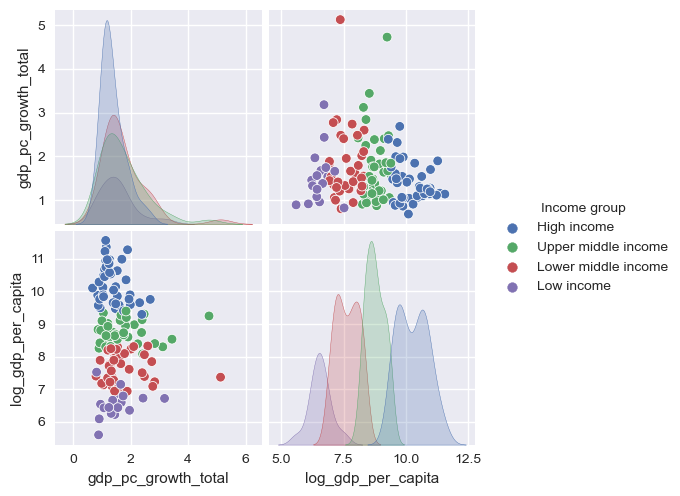

In [46]:
hue_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
sns.pairplot(gdp_sns_plots[['gdp_pc_growth_total','log_gdp_per_capita','Income group'#'inflation_pp',
                               #'heatwave_days','mean_temp', 'precip',
                              ]], hue='Income group', hue_order=hue_order)

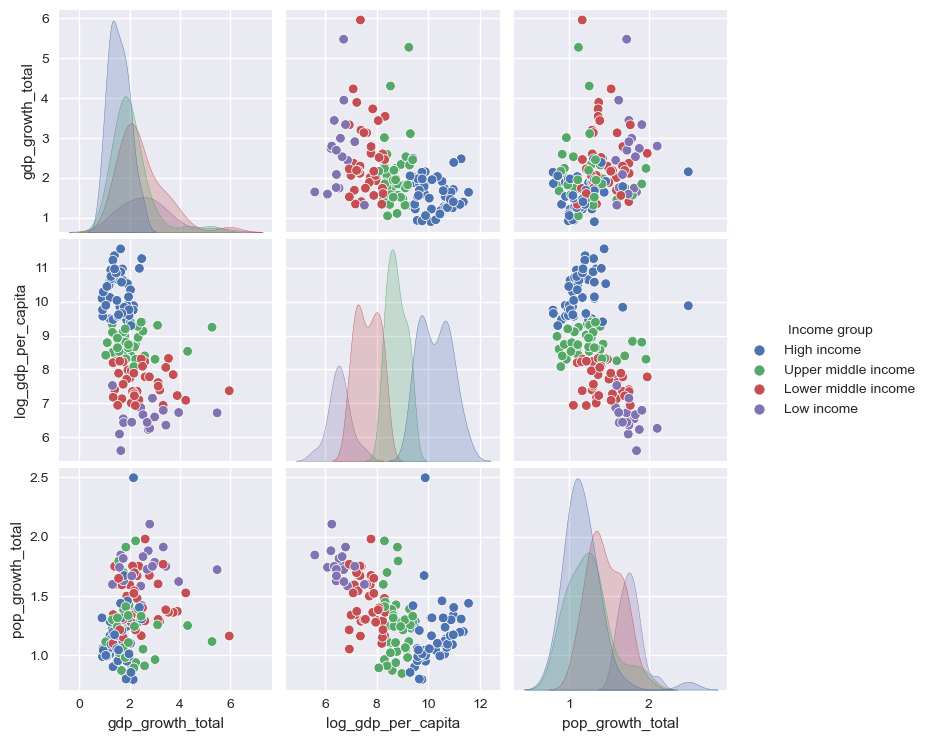

In [47]:
hue_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
sns.pairplot(gdp_sns_plots[['gdp_growth_total','log_gdp_per_capita','pop_growth_total','Income group'#'inflation_pp',
                               #'heatwave_days','mean_temp', 'precip',
                              ]], hue='Income group', hue_order=hue_order)

C:\Users\ncozz\anaconda3\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


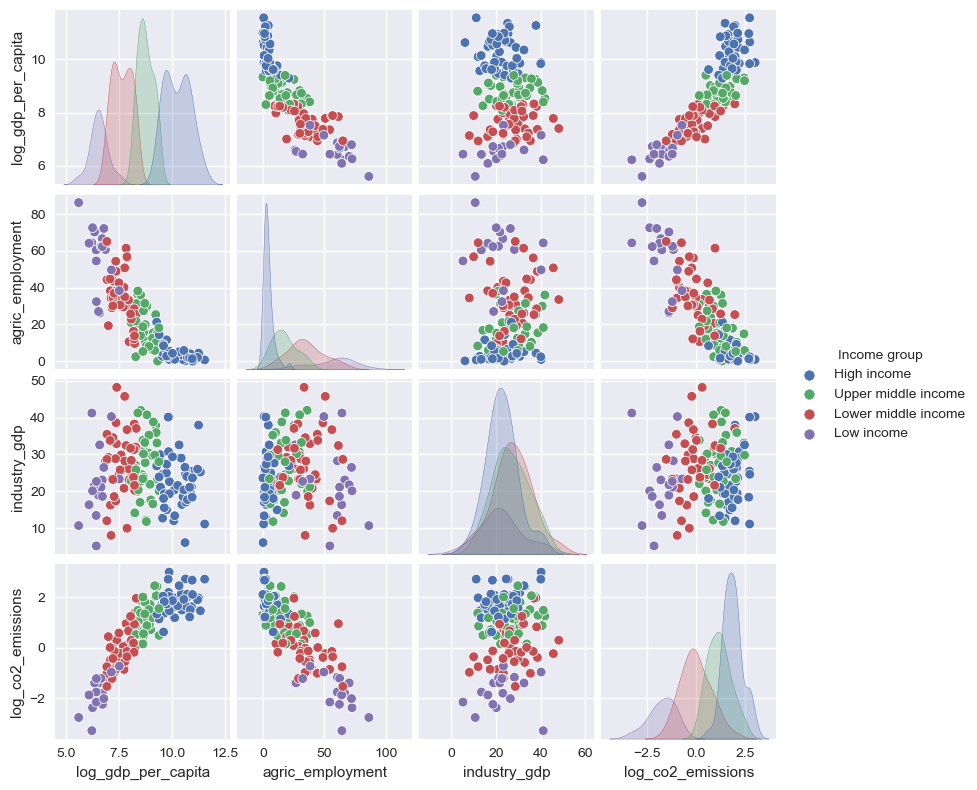

In [48]:
hue_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
sns.pairplot(gdp_sns_plots[['log_gdp_per_capita', 'Income group',#'inflation_pp',
                               'agric_employment',
                               'industry_gdp','log_co2_emissions'
                               #'heatwave_days','mean_temp', 'precip',
                              ]], hue='Income group', hue_order=hue_order, size=2)

C:\Users\ncozz\anaconda3\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


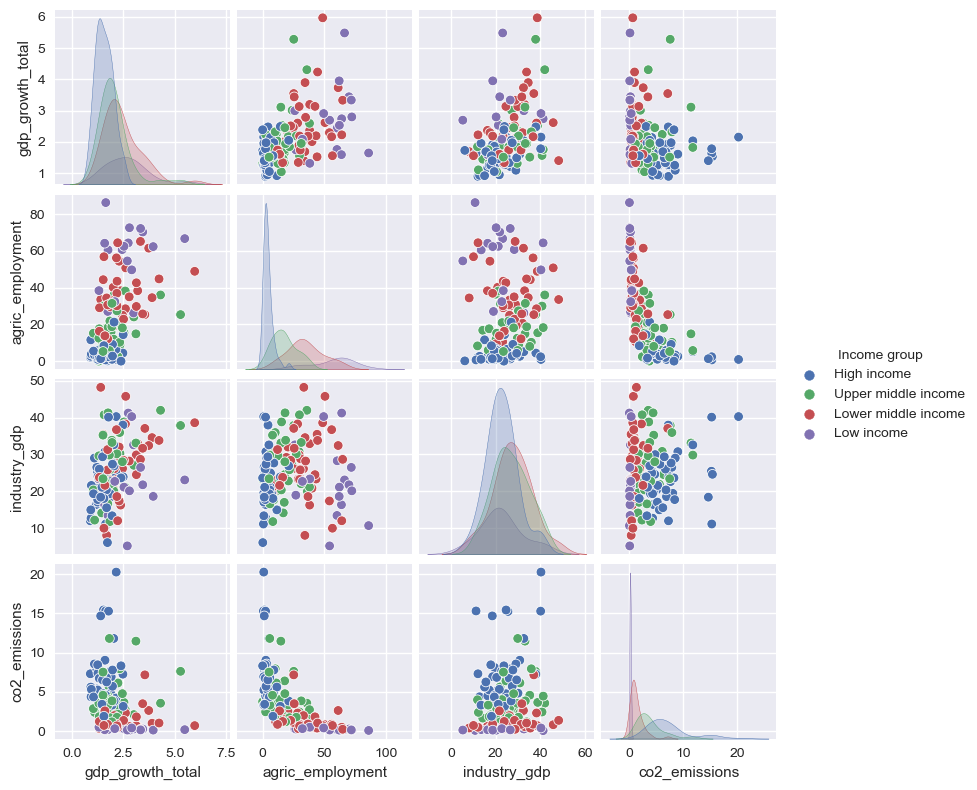

In [49]:
hue_order = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']
sns.pairplot(gdp_sns_plots[['gdp_growth_total', 'Income group',#'inflation_pp',
                               'agric_employment',
                               'industry_gdp','co2_emissions'
                               #'heatwave_days','mean_temp', 'precip',
                              ]], hue='Income group', hue_order=hue_order, size=2)

## Anomaly/outlier detection:

In this section, we attempt to find countries with outlying observations, and try to identify whether they are such because of remarkable economic conditions, due to major outlier events - crisis, civil war, epidemic, etcetera -, or due to data quality issues

We attempt four outlier detection algorithms:
* **One-class SVM:** adaptation of support vector machine, attempting to create maximum separation between points and origin, and labeling the anomalous observations
* **Local outlier factor:** K-nearest neighbors (KNN) based outlier detection algorithm
* **Isolation forest:** decision rule-based technique with random forest implementation, defines outliers as observations with shorter-than-average path lengths (in the decision tree)
* **Gaussian mixture model:** a probability-based approach for assessing outliers

For this purpose we first scale data and preprocess it in a similar fashion to the subsequent section:

In [50]:
classifications.head()

,ISO3,Income group
0,ABW,High income
1,AFG,Low income
2,AGO,Lower middle income
3,ALB,Upper middle income
4,AND,High income


-----------------
Here we use a similar preprocessing step as the next section (building ML models)

Valiables are scaled for distance-based algorithms

In [51]:
gdp_df.head()

,ISO3,Year,gdp_real_gwt_next,gdp_real_gwt_prev,gdp_real_gwt,gdp_real_us_fixed,gdp_per_capita,gdp_pp_govt,gdp_pp_private,inflation_pp,unemployment,renew_energy,agric_employment,vulnerable_employment,imports,exports,foreign_inv,real_interest_rate,cab,population,pop_density,pop_growth,life_expectancy,death_rate,child_mortality,renewable_energy_output,agric_land,agff_gdp,arable_land,rural_pop,electricity_access,fuel_exports,metal_exports,co2_emissions,industry_gdp,service_value_added
2927,ZMB,2001,4.506014,3.897323,5.316868,8.487518e+09,793.804887,NaN,NaN,25.331258,NaN,89.76,71.230003,81.740002,39.558584,25.109699,1.450000e+08,16.677463,-18.000611,10692197.0,14.383025,2.617671,44.615000,17.395,146.9,99.370515,30.340736,15.527482,3.661604,64.998,20.172386,1.155972,60.421526,0.172088,23.360612,4467.040050
2933,VUT,2001,-5.198319,5.924809,-3.397582,5.068359e+08,2678.709047,20.512273,76.512807,3.624906,NaN,47.42,69.059998,74.479996,49.815902,37.956243,1.800432e+07,5.006127,0.705178,189209.0,15.521657,2.269101,67.583000,5.999,28.3,0.000000,14.520098,23.529883,1.640689,78.047,23.943880,NaN,NaN,0.475664,9.047492,NaN
2934,UZB,2001,3.973488,3.835000,4.163838,3.278312e+10,1313.192271,18.500010,57.826082,45.239476,0.40,0.78,38.169998,46.840000,27.101172,29.675106,8.280000e+07,NaN,NaN,24964450.0,57.269603,1.265969,67.374000,5.300,57.4,12.545610,62.684814,29.973809,10.279621,53.394,99.630104,NaN,NaN,5.035160,19.952084,2730.392153
2935,URY,2001,-7.732007,-1.929931,-3.844130,3.218762e+10,9679.115577,12.492042,75.880212,4.826618,15.05,41.63,11.390000,24.829999,19.504853,16.804659,3.104029e+08,43.206421,-2.381135,3325471.0,19.000520,0.172666,74.939000,9.404,16.5,99.794595,85.487373,5.586703,7.867672,7.697,97.785393,1.944998,0.578067,1.488511,21.935134,20931.279347
2936,USA,2001,1.695943,4.077159,0.954339,1.388556e+13,48726.581673,14.535638,66.847930,2.252952,4.73,4.68,1.530000,4.520000,13.263734,9.703447,1.724960e+11,4.565848,-3.724075,284968955.0,31.103628,0.989741,76.836585,8.500,8.3,6.783992,45.290070,1.129257,19.144459,20.766,100.000000,1.880775,1.912058,20.171531,21.469004,100596.153467


In [52]:
pd.set_option("display.max_rows", 20)
wb_out = gdp_df.copy()
wb_out = wb_out.sort_values(by=['Year','ISO3'],ascending=[True,True])

In [53]:
# adding continent code
continents = []
for iso3 in wb_out.ISO3:
    try:
        continents = continents + [pycountry_convert.country_alpha2_to_continent_code(pycountry_convert.country_alpha3_to_country_alpha2(iso3))]
    except:
        continents = continents + ['OTHER']
        
wb_out.insert(0, 'continent_code', continents, 'continent_code')

In [54]:
wb_out = wb_out.merge(classifications[['ISO3','Income group']], how='left')
wb_out.columns = wb_out.columns.str.replace('Income group', 'income_group')
wb_out = wb_out[['income_group'] + [col for col in wb_out.columns if col != 'income_group']]
col_group = 'ISO3'
for df in [wb_out]:
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.ffill().bfill())
col_group = ['income_group','continent_code','Year']
for df in [wb_out]:
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))
col_group = ['income_group','continent_code']
for df in [wb_out]:
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))
col_group = ['income_group']
for df in [wb_out]:
    list_cols = df.isna().sum(0)[df.isna().sum(0)>0].index
    for colname in list_cols:
        df[colname] = df.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))
index_target = wb_out.columns.get_loc("gdp_real_gwt_next")
# normalize data except for booleans:
for df in [wb_out]:
    df.iloc[:,index_target:] = StandardScaler().fit_transform(df.iloc[:,index_target:])

x_out = wb_out.iloc[:,(index_target):]
y_out = wb_out.iloc[:,index_target]

### One-class SVM:

In [55]:
oc_svm = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.05)
oc_svm.fit(x_out)
pred = oc_svm.predict(x_out)
index_svm_out = np.where(pred==-1)
index_svm_out = index_svm_out[0].tolist()
values = x_out.iloc[index_svm_out,:]

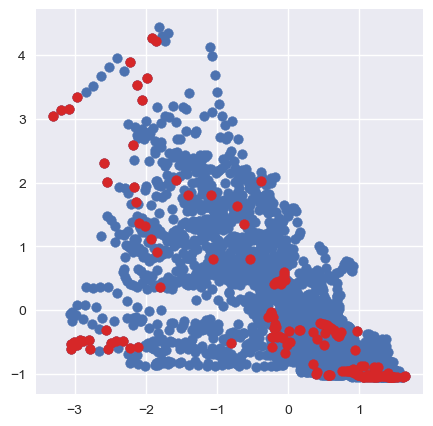

In [56]:
# for visualization, choose whichever covariates you prefer

plt.rcParams["figure.figsize"] = (5, 5)
plt.scatter(x_out.loc[:,'life_expectancy'], x_out.loc[:,'agff_gdp'])
plt.scatter(values.loc[:,'life_expectancy'], values.loc[:,'agff_gdp'], color='tab:red')
plt.show()

### Local Outlier Factor (LOF):

In [57]:
# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred = clf.fit_predict(x_out)
X_scores = clf.negative_outlier_factor_

In [58]:
X_scores[X_scores<-np.quantile(X_scores, 0.05)]

array([-1.73017895, -0.99462921, -1.4138593 , ..., -1.14655576,
       -1.02925784, -1.12030173])

<AxesSubplot:ylabel='Density'>

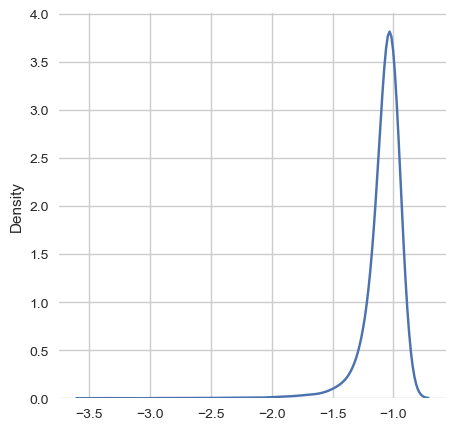

In [59]:
sns.set_style('whitegrid')
sns.kdeplot(X_scores, bw_method=0.5)

In [60]:
x_out.columns

Index(['gdp_real_gwt_next', 'gdp_real_gwt_prev', 'gdp_real_gwt',
       'gdp_real_us_fixed', 'gdp_per_capita', 'gdp_pp_govt', 'gdp_pp_private',
       'inflation_pp', 'unemployment', 'renew_energy', 'agric_employment',
       'vulnerable_employment', 'imports', 'exports', 'foreign_inv',
       'real_interest_rate', 'cab', 'population', 'pop_density', 'pop_growth',
       'life_expectancy', 'death_rate', 'child_mortality',
       'renewable_energy_output', 'agric_land', 'agff_gdp', 'arable_land',
       'rural_pop', 'electricity_access', 'fuel_exports', 'metal_exports',
       'co2_emissions', 'industry_gdp', 'service_value_added'],
      dtype='object')

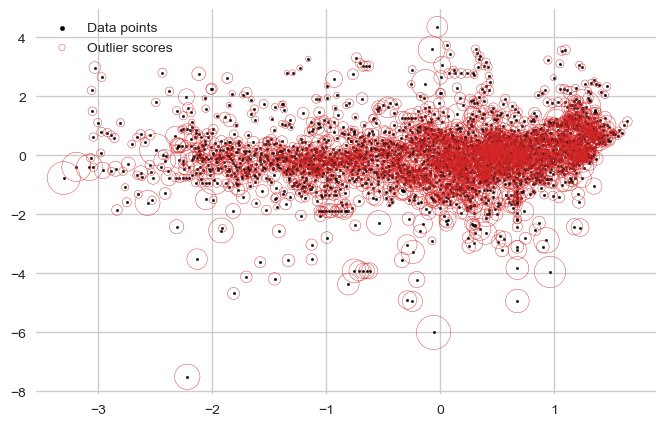

In [61]:
x_axis_col = 'life_expectancy'
y_axis_col = 'cab'

plt.rcParams["figure.figsize"] = (8, 5)
#plt.title("Local Outlier Factor (LOF)")
plt.scatter(x_out.loc[:,x_axis_col], x_out.loc[:,y_axis_col], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    x_out.loc[:,x_axis_col],
    x_out.loc[:,y_axis_col],
    s=1000 * radius,
    edgecolors="tab:red",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
#plt.xlim((-5, 5))
#plt.ylim((-5, 5))
# plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

### Isolation forests:

In [62]:
# fit the model
iso_forest = IsolationForest(max_samples=500, n_estimators=100, contamination=0.05, random_state=777)
predictions = iso_forest.fit_predict(x_out)

C:\Users\ncozz\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [63]:
outlier_index_if = np.where(predictions==-1)
outlier_index_if = outlier_index_if[0].tolist()
values = x_out.iloc[outlier_index_if]

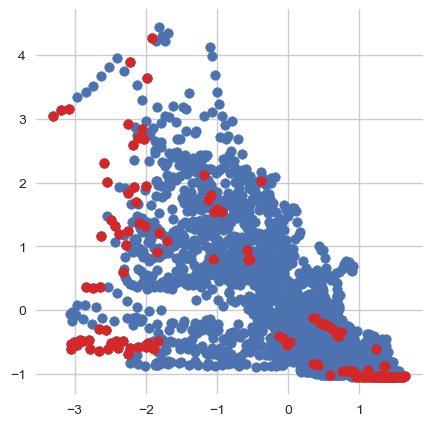

In [64]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.scatter(x_out.loc[:,'life_expectancy'], x_out.loc[:,'agff_gdp'])
plt.scatter(values.loc[:,'life_expectancy'], values.loc[:,'agff_gdp'], color='tab:red')
plt.show()

### Gaussian Mixture:

In [65]:
gausMix = KernelDensity().fit(x_out)

In [66]:
scores = gausMix.score_samples(x_out)
thresh = np.quantile(scores, .05)

In [67]:
outlier_index_gm = np.where(scores <= thresh)
outlier_index_gm = outlier_index_gm[0].tolist()
values = x_out.iloc[outlier_index_gm]

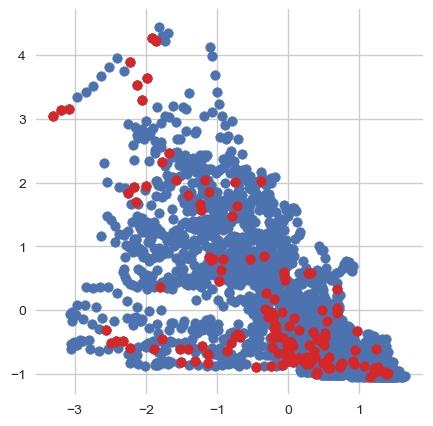

In [68]:
plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(x_out.loc[:,'life_expectancy'], x_out.loc[:,'agff_gdp'])
plt.scatter(values.loc[:,'life_expectancy'], values.loc[:,'agff_gdp'], color='tab:red')
plt.show()

### Deleting outlier observations/countries:

In [69]:
len(wb_out)

2860

In [70]:
outliers_svm = wb_out.iloc[index_svm_out]
outliers_svm = outliers_svm.groupby(['ISO3']).size().reset_index(name='counts')

In [71]:
index_lof_out = [i for i in range(len(X_scores)) if X_scores[i] < np.quantile(X_scores, 0.05)]
outliers_lof = wb_out.iloc[index_lof_out]
outliers_lof = outliers_lof.groupby(['ISO3']).size().reset_index(name='counts')

In [72]:
outliers_if = wb_out.iloc[outlier_index_if]
outliers_if = outliers_if.groupby(['ISO3']).size().reset_index(name='counts')

In [73]:
outliers_gm = wb_out.iloc[outlier_index_gm]
outliers_gm = outliers_gm.groupby(['ISO3']).size().reset_index(name='counts')

In [74]:
outliers_full = pd.merge(outliers_svm,outliers_lof,how='outer',on='ISO3')
outliers_full = pd.merge(outliers_full,outliers_if,how='outer',on='ISO3')
outliers_full = pd.merge(outliers_full,outliers_gm,how='outer',on='ISO3')
outliers_full.columns = ['ISO3','counts_svm','counts_lof','counts_if','counts_gm']
outliers_full['counts_total'] = outliers_full.fillna(0).sum(axis=1)
pd.set_option("display.max_rows", None)
outliers_full.sum(axis=0)

C:\Users\ncozz\AppData\Local\Temp\ipykernel_11252\264830448.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'counts_x'} in the result is deprecated and will raise a MergeError in a future version.
  outliers_full = pd.merge(outliers_full,outliers_gm,how='outer',on='ISO3')
C:\Users\ncozz\AppData\Local\Temp\ipykernel_11252\264830448.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  outliers_full['counts_total'] = outliers_full.fillna(0).sum(axis=1)


ISO3            AGOAZEBDIBHRBHSBLRCHECHNCODCOGGINGMBGUYHKGINDI...
counts_svm                                                  145.0
counts_lof                                                  143.0
counts_if                                                   143.0
counts_gm                                                   143.0
counts_total                                                574.0
dtype: object

Let us consider potential outliers as all countries that sum 20 or more outlier observations between all 4 algorithms:

In [75]:
outliers_full[outliers_full.counts_total>=15]

,ISO3,counts_svm,counts_lof,counts_if,counts_gm,counts_total
0,AGO,6.0,5.0,8.0,7.0,26.0
1,AZE,6.0,8.0,4.0,6.0,24.0
7,CHN,11.0,NaN,13.0,NaN,24.0
9,COG,1.0,3.0,2.0,9.0,15.0
13,HKG,7.0,NaN,11.0,NaN,18.0
16,IRQ,7.0,6.0,NaN,13.0,26.0
17,LSO,10.0,NaN,14.0,NaN,24.0
18,LUX,11.0,NaN,11.0,NaN,22.0
20,MDV,4.0,7.0,NaN,8.0,19.0
29,SGP,11.0,NaN,18.0,1.0,30.0


In [76]:
threshold_out = 15
for iso in outliers_full[outliers_full.counts_total >= threshold_out].sort_values('ISO3', ascending=True).ISO3.unique():
    try:
        print(iso + ' | ' + pycountry.countries.get(alpha_3=iso).name)
    except:
        print(iso + ' | ' + '------------ NONE')

AGO | Angola
AZE | Azerbaijan
BWA | Botswana
CHN | China
COG | Congo
HKG | Hong Kong
IRQ | Iraq
LSO | Lesotho
LUX | Luxembourg
MDV | Maldives
SGP | Singapore
SLE | Sierra Leone
USA | United States


In [77]:
outliers_list = outliers_full[outliers_full.counts_total >= threshold_out].ISO3.unique()
#for country in outliers_list:
#    print(wb_out[wb_out.ISO3 == country])

In [78]:
outliers_full[outliers_full.counts_total >= threshold_out].ISO3.unique()

array(['AGO', 'AZE', 'CHN', 'COG', 'HKG', 'IRQ', 'LSO', 'LUX', 'MDV',
       'SGP', 'SLE', 'USA', 'BWA'], dtype=object)

In [79]:
listno=-1
listno=listno+1
wb_out[wb_out.ISO3==outliers_full[outliers_full.counts_total >= threshold_out].ISO3.unique()[listno]].iloc[:,1:]

,continent_code,ISO3,Year,gdp_real_gwt_next,gdp_real_gwt_prev,gdp_real_gwt,gdp_real_us_fixed,gdp_per_capita,gdp_pp_govt,gdp_pp_private,inflation_pp,unemployment,renew_energy,agric_employment,vulnerable_employment,imports,exports,foreign_inv,real_interest_rate,cab,population,pop_density,pop_growth,life_expectancy,death_rate,child_mortality,renewable_energy_output,agric_land,agff_gdp,arable_land,rural_pop,electricity_access,fuel_exports,metal_exports,co2_emissions,industry_gdp,service_value_added
0,OTHER,AGO,2001,2.201176,-0.216961,0.164486,-0.247002,-0.610975,1.750661,-1.336402,9.742223,2.615718,1.298366,0.452959,0.825143,1.028025,1.084534,-0.224958,-1.389689,-1.610748,-0.181410,-0.272655,1.605402,-2.565801,2.982084,4.052359,0.791327,-0.098602,-0.308545,-0.978415,0.261694,-1.994517,3.426957,-0.423403,-0.705347,3.919644,-0.640979
143,OTHER,AGO,2002,-0.130493,0.076343,2.262821,-0.244464,-0.600884,0.628706,-1.496928,18.545828,2.615718,1.232306,0.424223,0.816480,0.066893,0.487329,-0.234512,-5.007384,0.195751,-0.177731,-0.272104,1.628557,-2.495144,2.816999,3.879052,0.872393,-0.077300,-0.518320,-0.972577,0.208532,-1.781040,3.426957,-0.423403,-0.715932,3.031145,-0.640979
286,OTHER,AGO,2003,1.608044,2.486126,-0.105245,-0.243832,-0.601365,1.135981,-1.400344,8.535257,2.615718,1.050642,0.419433,0.816119,0.115907,0.397159,-0.190935,-0.608141,-0.171731,-0.173871,-0.271526,1.669390,-2.414049,2.632052,3.685652,0.794896,-0.055998,-0.485830,-0.960903,0.155504,-1.745394,3.426957,-0.423403,-0.709228,2.732679,-0.637836
429,OTHER,AGO,2004,2.499154,-0.233423,1.660431,-0.241451,-0.593384,-0.268722,-1.489869,2.660197,2.615718,0.939855,0.407242,0.773168,-0.041595,0.529593,-0.223728,3.896037,0.661394,-0.169788,-0.270915,1.730553,-2.323613,2.430499,3.467135,1.286505,-0.034695,-0.481077,-0.960903,0.102566,-1.709845,3.426957,-0.423403,-0.707994,2.885294,-0.631069
572,OTHER,AGO,2005,1.739090,1.794325,2.565450,-0.237825,-0.580247,0.051057,-2.135440,3.527683,2.615718,1.162118,0.491710,0.769198,-0.190273,0.762743,-0.306940,1.506679,1.983978,-0.165457,-0.270266,1.800308,-2.224496,2.214618,3.241083,1.324233,-0.013393,-0.588867,-0.960903,0.050031,-1.674314,3.426957,-0.423403,-0.734708,3.467545,-0.615028
715,OTHER,AGO,2006,2.276377,2.833673,1.793522,-0.234619,-0.570219,-0.076953,-2.329624,1.074172,2.615718,0.947080,0.583145,0.802765,-0.546513,0.695584,-0.276847,-0.491871,2.766466,-0.160864,-0.269579,1.867890,-2.117028,1.986365,2.997449,1.353450,0.007909,-0.577017,-0.960903,0.015813,-1.638721,3.426957,-0.423403,-0.732808,3.236275,-0.596785
858,OTHER,AGO,2007,1.656094,1.947170,2.339195,-0.230282,-0.556151,-0.040595,-2.200382,-0.169869,2.615718,0.821842,0.670226,0.813593,-0.223009,0.840380,-0.297183,0.877072,2.262241,-0.156020,-0.268854,1.918190,-2.003406,1.750622,2.761350,1.262648,0.029212,-0.572399,-0.955066,-0.018225,-1.406390,3.426957,-0.423403,-0.735116,3.616995,-0.584347
1001,OTHER,AGO,2008,-0.595705,2.573836,1.709231,-0.226339,-0.545021,0.197367,-2.346394,1.292738,2.615718,0.697636,0.764273,0.844994,0.091089,0.989461,-0.236046,-1.477313,1.290328,-0.150953,-0.268095,1.942883,-1.886268,1.512926,2.527762,1.195585,0.050514,-0.611961,-0.955066,-0.052173,-1.373119,3.426957,-0.423403,-0.717516,3.452699,-0.552572
1144,OTHER,AGO,2009,0.277932,1.850368,-0.577719,-0.226002,-0.549722,0.771744,-1.449868,-2.216575,-0.697311,0.612654,0.857450,0.993700,0.623222,0.541892,-0.223536,4.192866,-0.980550,-0.145703,-0.267309,1.937349,-1.768910,1.279137,2.301710,0.890115,0.071816,-0.447546,-0.920043,-0.085853,-1.530663,3.455509,-0.466408,-0.705901,1.818697,-0.526601
1287,OTHER,AGO,2010,-0.025657,-0.776025,0.309555,-0.224078,-0.547964,0.239782,-1.878503,2.489683,0.245218,0.616094,0.960641,1.009221,-0.135769,0.632785,-0.352654,-1.632117,1.417930,-0.140304,-0.266501,1.910682,-1.654739,1.055442,2.093240,0.969450,0.093118,-0.487468,-0.914206,-0.119398,-1.493916,3.455145,-0.464134,-0.697484,2.657168,-0.480192


In [80]:
pd.set_option("display.max_rows", 20)

### Removing outliers (final):

Countries removed are:
* China, due to data reliability issues
* Iraq, due to conflict's impact in GDP

Others removed (domain knowledge):
* Sudan, due to the civil war that led to the separation of South Sudan - and issues with the data being mixed between these two nations
* Timor Leste - data quality issues
* Republic of the Congo, due to low data quality

In [81]:
outliers_to_remove = ['CHN','SDN','TLS','COG','IRQ']

In [82]:
gdp_df_final = gdp_df.copy()[~gdp_df.ISO3.isin(outliers_to_remove)]

In [83]:
gdp_df_final.shape

(2780, 36)

In [84]:
# REMOVING outliers from benchmark
def remove_countries_df(df, list_out):
    return df[~df.ISO3.isin(list_out)]
merge_fc_1S = remove_countries_df(merge_fc_1S, outliers_to_remove)
merge_fc_1F = remove_countries_df(merge_fc_1F, outliers_to_remove)

In [85]:
merge_fc_1S

,ISO3,Year,pop_growth_next,gdp_real_gwt_next,gdp_real_gwt_prev,gdp_real_gwt,gdp_real_us_fixed,gdp_per_capita,gdp_pp_govt,gdp_pp_private,investment,inflation_pp,renew_energy,unemployment,employment,HCI,agric_employment,vulnerable_employment,pop_slums,renew_freshwater,imports,exports,foreign_inv,govt_debt,real_interest_rate,poverty_1.90,poverty_3.20,poverty_5.50,poverty_multidim,poverty_mult_index,gini_index,cab,population,pop_density,pop_growth,life_expectancy,death_rate,child_mortality,cause_of_death,renewable_energy_output,agric_land,agff_gdp,arable_land,rural_pop,electricity_access,power_consumption,fuel_exports,metal_exports,co2_emissions,ghg_emissions,industry_gdp,service_value_added,school_enroll,literacy,bachelor,homicide,research,country,WEO_Country_Code,ISOAlpha_3Code,year,year_report,gdp_pc_weo
1,ZMB,2001,2.580537,4.506014,3.897323,5.316868,8.487518e+09,793.804887,NaN,NaN,1.789134,25.331258,89.76,NaN,NaN,NaN,71.230003,81.740002,NaN,NaN,39.558584,25.109699,1.450000e+08,NaN,16.677463,NaN,NaN,NaN,NaN,NaN,NaN,-18.000611,10692197.0,14.383025,2.617671,44.615000,17.395,146.9,NaN,99.370515,30.340736,15.527482,3.661604,64.998,20.172386,618.675470,1.155972,60.421526,0.172088,NaN,23.360612,4467.040050,NaN,NaN,NaN,NaN,NaN,Zambia,754.0,ZMB,2002.0,2001.0,5.004406
3,VUT,2001,2.462958,-5.198319,5.924809,-3.397582,5.068359e+08,2678.709047,20.512273,76.512807,NaN,3.624906,47.42,NaN,NaN,NaN,69.059998,74.479996,NaN,NaN,49.815902,37.956243,1.800432e+07,NaN,5.006127,NaN,NaN,NaN,NaN,NaN,NaN,0.705178,189209.0,15.521657,2.269101,67.583000,5.999,28.3,NaN,0.000000,14.520098,23.529883,1.640689,78.047,23.943880,NaN,NaN,NaN,0.475664,NaN,9.047492,NaN,0.96612,NaN,NaN,NaN,NaN,Vanuatu,846.0,VUT,2002.0,2001.0,3.037
4,UZB,2001,1.223832,3.973488,3.835000,4.163838,3.278312e+10,1313.192271,18.500010,57.826082,NaN,45.239476,0.78,0.40,NaN,NaN,38.169998,46.840000,NaN,NaN,27.101172,29.675106,8.280000e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24964450.0,57.269603,1.265969,67.374000,5.300,57.4,NaN,12.545610,62.684814,29.973809,10.279621,53.394,99.630104,1769.396081,NaN,NaN,5.035160,NaN,19.952084,2730.392153,NaN,NaN,NaN,4.305306,614.611023,Uzbekistan,927.0,UZB,2002.0,2001.0,1.000004
5,URY,2001,0.017289,-7.732007,-1.929931,-3.844130,3.218762e+10,9679.115577,12.492042,75.880212,1.576256,4.826618,41.63,15.05,52.290001,NaN,11.390000,24.829999,NaN,NaN,19.504853,16.804659,3.104029e+08,40.643335,43.206421,NaN,NaN,NaN,NaN,NaN,NaN,-2.381135,3325471.0,19.000520,0.172666,74.939000,9.404,16.5,NaN,99.794595,85.487373,5.586703,7.867672,7.697,97.785393,2001.220278,1.944998,0.578067,1.488511,NaN,21.935134,20931.279347,1.04951,NaN,NaN,6.555462,NaN,Uruguay,298.0,URY,2002.0,2001.0,3.982396
6,USA,2001,0.927797,1.695943,4.077159,0.954339,1.388556e+13,48726.581673,14.535638,66.847930,1.483869,2.252952,4.68,4.73,63.660000,NaN,1.530000,4.520000,NaN,NaN,13.263734,9.703447,1.724960e+11,52.443676,4.565848,0.7,1.0,1.7,NaN,NaN,40.6,-3.724075,284968955.0,31.103628,0.989741,76.836585,8.500,8.3,NaN,6.783992,45.290070,1.129257,19.144459,20.766,100.000000,13046.614148,1.880775,1.912058,20.171531,-635.810488,21.469004,100596.153467,NaN,NaN,NaN,6.687444,3566.030029,United States,111.0,USA,2002.0,2001.0,2.532755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3095,ARG,2020,0.947491,10.263761,-2.025934,-9.895269,5.147724e+11,11344.405742,15.531411,63.519675,NaN,39.891217,NaN,11.46,49.599998,0.602145,NaN,NaN,NaN,NaN,13.556325,16.591817,4.722649e+09,NaN,-7.508490,1.1,3.5,14.1,NaN,NaN,42.3,0.850315,45376763.0,16.580893,0.970054,76.813000,7.602,8.6,NaN,NaN,39.603229,5.932404,11.924171,7.889,100.000000,NaN,2.678988,0.217989,NaN,NaN,23.311218,NaN,NaN,NaN,NaN,5.345632,NaN,Argentina,213.0,ARG,2021.0,2020.0,4.448186
3096,ATG,2020,0.813608,5.270849,4.862236,-20.192371,1.301037e+09,13285.644742,19.336114,60.0

In [88]:
def create_error_fc_df(df):
    return pd.DataFrame({
        'year_fc': list(range(start_year+1,end_year+2)),
        'mae': [mae_forecast_scaled(df[df.year == x].gdp_real_gwt_next, df[df.year == x].gdp_pc_weo) for x in list(range(start_year+1,end_year+2))],
        'mse': [mse_forecast_scaled(df[df.year == x].gdp_real_gwt_next, df[df.year == x].gdp_pc_weo) for x in list(range(start_year+1,end_year+2))]
    })

In [89]:
errors_fc_1S = create_error_fc_df(merge_fc_1S)

errors_fc_1S

,year_fc,mae,mse
0,2002,0.613008,0.943066
1,2003,0.700275,0.910473
2,2004,0.694081,0.887925
3,2005,0.571742,0.744357
4,2006,0.619021,1.012728
5,2007,0.694610,0.929395
6,2008,0.681540,0.892138
7,2009,1.063276,1.826856
8,2010,0.908558,1.251279
9,2011,0.559776,0.672142


In [90]:
errors_fc_1F = create_error_fc_df(merge_fc_1F)

errors_fc_1F

,year_fc,mae,mse
0,2002,0.583609,0.886665
1,2003,0.646123,0.797872
2,2004,0.700810,0.894845
3,2005,0.545464,0.776452
4,2006,0.594751,0.780552
5,2007,0.670240,0.947551
6,2008,0.687186,0.987645
7,2009,0.957644,1.512527
8,2010,0.757264,0.881722
9,2011,0.519540,0.618555


In [91]:
gdp_df_final.to_csv('data/gdp_df_final.csv', index=False)
errors_fc_1F.to_csv('data/errors_fc_1F.csv', index=False)
errors_fc_1S.to_csv('data/errors_fc_1S.csv', index=False)